In [1]:
import ppptm as gptm
import optax
import liesel.goose as gs
from liesel_ptm.util.plots import plot_loss, plot_param_history

In [2]:
def opt1():
    # Define the learning rate scheduler
    scheduler = optax.cosine_decay_schedule(init_value=0.01, decay_steps=2000)

    # Define the AdamW optimizer with weight decay
    adamw_optimizer = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)

    gradient_clipping = optax.clip_by_global_norm(1.0)

    # Combine them using optax.chain
    combined_optimizer = optax.chain(gradient_clipping, adamw_optimizer)
    return combined_optimizer

In [3]:
data = gptm.load_americas()

In [4]:
locs = gptm.LocationVars.new_from(data.locs, n_subset=256)
y = data.obs[:, locs.locs.ordering]
model = gptm.Model.new_G(
    y,
    locs,
    g_dist=gptm.G(y, locs, ard=True).new_gaussian(),
)

In [5]:
result = model.fit(
    stopper=gs.Stopper(max_iter=2_000, patience=30),
    optimizer=opt1(),
    progress_bar=False,
)

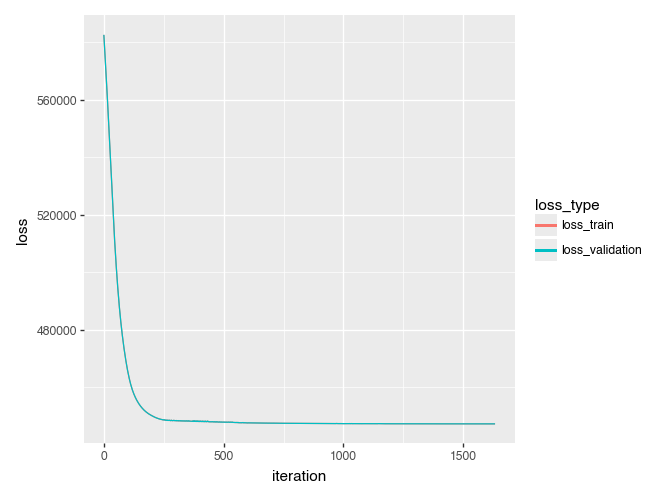

In [6]:
plot_loss(result)

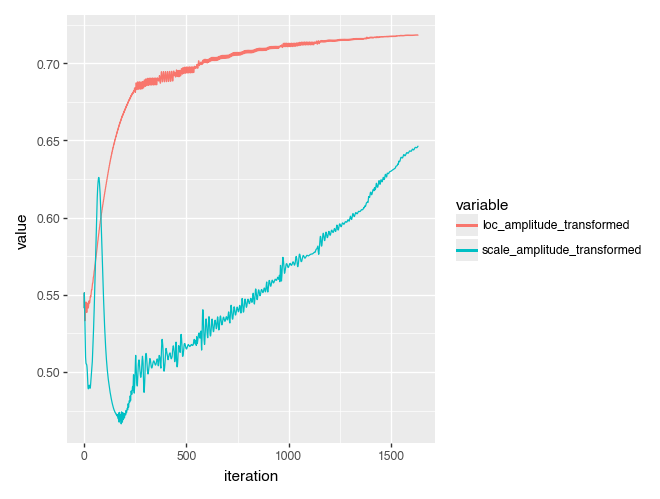

In [7]:
d = {k: v for k, v in result.history["position"].items() if "amplitude" in k}
plot_param_history(d)

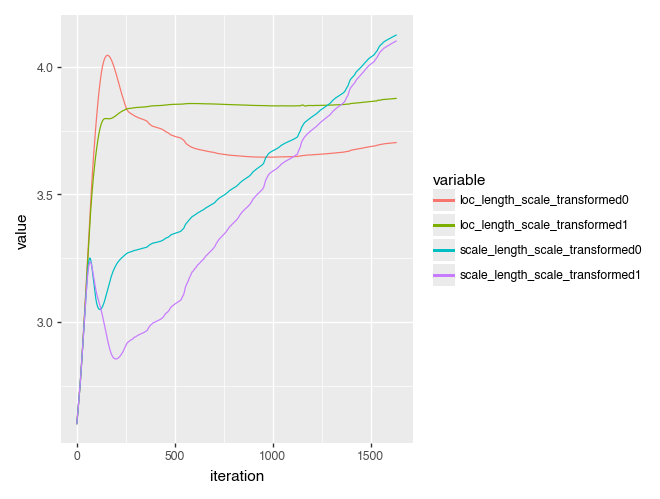

In [8]:
d = {k: v for k, v in result.history["position"].items() if "length_scale" in k}
plot_param_history(d)

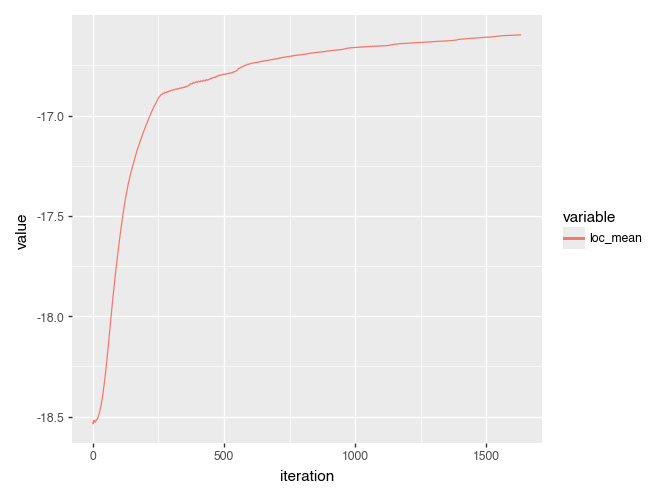

In [9]:
d = {k: v for k, v in result.history["position"].items() if "loc_mean" in k}
plot_param_history(d)

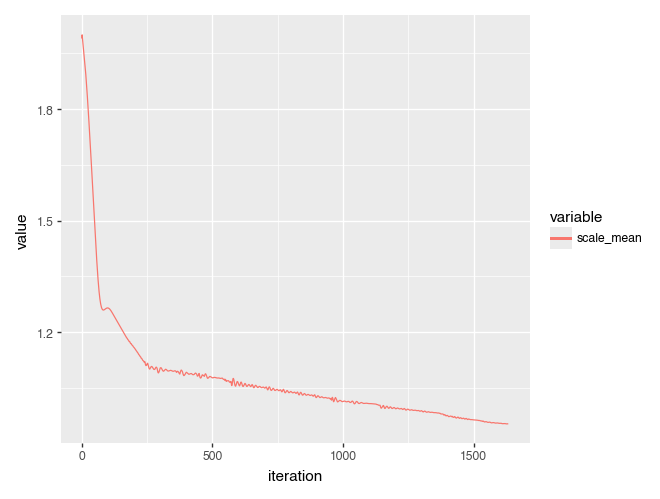

In [10]:
d = {k: v for k, v in result.history["position"].items() if "scale_mean" in k}
plot_param_history(d)

In [11]:
df = gptm.long_df_multiple(
    locs.locs.ordered,
    mu=model.graph.vars["loc"].value,
    sigma=model.graph.vars["scale"].value,
)

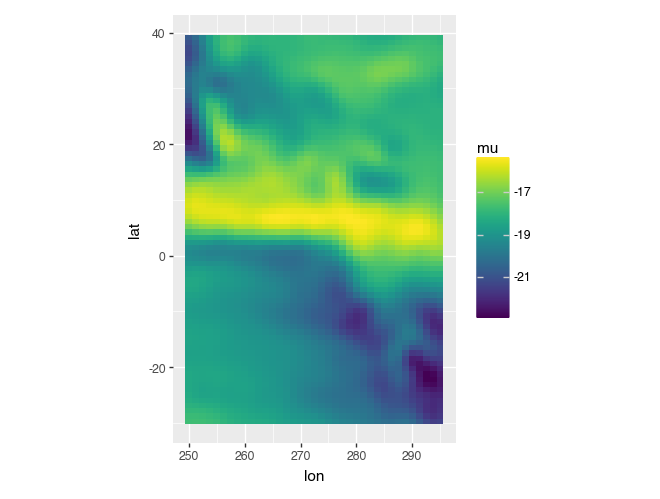

In [12]:
gptm.plot_df(df, "mu")

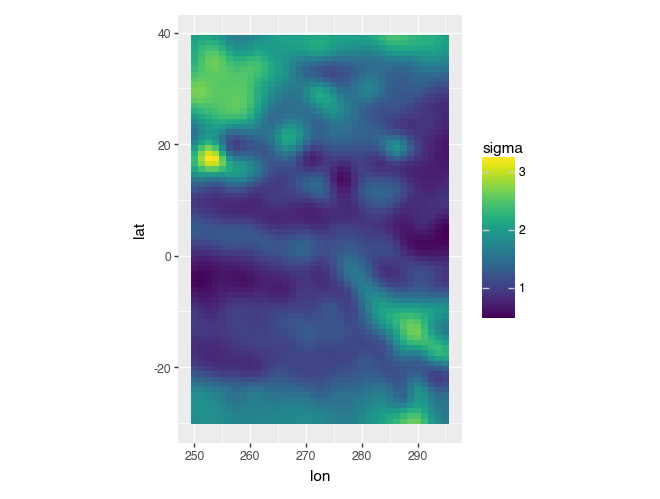

In [13]:
gptm.plot_df(df, "sigma")